# Import necessary libraries

In [1]:
import numpy as np
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cpu


In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
import importlib

## Import our own modules

In [8]:
import lib
importlib.reload(lib)

<module 'lib' from '/content/Learning-the-Optimal-Solution-Path/lib/__init__.py'>

In [9]:
from lib.fast_tensor_data_loader import FastTensorDataLoader
from lib.ngs.naive_grid_search import naive_grid_search
from lib.ngs.utils_ngs import get_sup_error
from lib.ngs.loss_fn import reg_exp_weighted_logit

# Load data

In [11]:
# file path for Colab. May need to change this
X_df = pd.read_csv('X_processed.csv')
y_df = pd.read_csv('y_processed.csv')

In [12]:
X = np.array(X_df)
y = np.array(y_df).squeeze()

In [13]:
train_X = torch.tensor(X, dtype=torch.float32)
train_y = torch.tensor(y, dtype=torch.float32)

In [14]:
# full gradient descent uses all data points
GD_data_loader = FastTensorDataLoader(train_X, train_y, batch_size=1000, shuffle=True, )
# test data
test_data_loader = FastTensorDataLoader(train_X, train_y, batch_size=1000, shuffle=False, )

In [15]:
lam_max = 20
lam_min = 0
input_dim = X.shape[1]

In [17]:
import time

In [18]:
# Read the CSV file into a DataFrame
# truth = pd.read_csv('/content/Learning-the-Optimal-Solution-Path/experiments/fair-regression/results/exact_soln_list.csv')
truth = pd.read_csv('exact_soln_list_laguerre.csv')

# Display the DataFrame
truth

,losses,theta_0,theta_1,theta_2,theta_3,theta_4,theta_5,theta_6,theta_7,theta_8,...,theta_36,theta_37,theta_38,theta_39,theta_40,theta_41,theta_42,theta_43,theta_44,theta_45
0,0.251592,-0.290164,0.186074,0.232884,-0.027476,0.166136,0.110354,0.142358,0.009975,0.157656,...,0.000471,0.023097,-0.007038,0.003151,0.004510,-0.024440,0.000471,-0.129229,-0.096597,-0.041242
1,0.251645,-0.290092,0.186073,0.232887,-0.027478,0.166136,0.110326,0.142336,0.009961,0.157669,...,0.000487,0.023069,-0.007039,0.003154,0.004514,-0.024434,0.000487,-0.129220,-0.096579,-0.041224
2,0.251698,-0.290020,0.186071,0.232891,-0.027481,0.166136,0.110298,0.142315,0.009946,0.157682,...,0.000503,0.023042,-0.007041,0.003157,0.004518,-0.024429,0.000503,-0.129210,-0.096561,-0.041206
3,0.251751,-0.289947,0.186070,0.232895,-0.027484,0.166136,0.110270,0.142294,0.009931,0.157695,...,0.000519,0.023015,-0.007042,0.003160,0.004522,-0.024423,0.000519,-0.129201,-0.096543,-0.041188
4,0.251804,-0.289874,0.186068,0.232898,-0.027487,0.166136,0.110242,0.142272,0.009916,0.157708,...,0.000534,0.022988,-0.007043,0.003162,0.004526,-0.024417,0.000534,-0.129191,-0.096525,-0.041170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,0.425709,0.608973,0.015982,0.030750,-0.012680,0.033522,-0.189898,-0.060873,-0.075246,0.138251,...,0.104496,-0.190631,-0.003899,0.016846,0.022910,0.049139,0.104496,0.117941,0.139251,0.161150
1020,0.405809,0.627298,0.006731,0.017247,-0.013635,0.025534,-0.197376,-0.075369,-0.070611,0.125166,...,0.104706,-0.193085,-0.002800,0.016029,0.021890,0.052167,0.104706,0.126507,0.144123,0.163584
1021,0.382318,0.647696,-0.004087,0.001661,-0.014793,0.016128,-0.205935,-0.094402,-0.064959,0.109066,...,0.104903,-0.195830,-0.001589,0.015089,0.020769,0.055620,0.104903,0.136154,0.149574,0.166138
1022,0.354260,0.670989,-0.016946,-0.016535,-0.016181,0.004871,-0.216011,-0.119855,-0.058109,0.089182,...,0.105111,-0.199002,-0.000252,0.014026,0.019573,0.059569,0.105111,0.147241,0.155866,0.168880


In [19]:
selected_columns = ['theta_0', 'theta_1', 'theta_2', 'theta_3', 'theta_4',
                    'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9',
                    'theta_10', 'theta_11', 'theta_12', 'theta_13', 'theta_14',
                    'theta_15', 'theta_16', 'theta_17', 'theta_18', 'theta_19',
                    'theta_20', 'theta_21', 'theta_22', 'theta_23', 'theta_24',
                    'theta_25', 'theta_26', 'theta_27', 'theta_28', 'theta_29',
                    'theta_30', 'theta_31', 'theta_32', 'theta_33', 'theta_34',
                    'theta_35', 'theta_36', 'theta_37', 'theta_38', 'theta_39',
                    'theta_40', 'theta_41', 'theta_42', 'theta_43', 'theta_44',
                    'theta_45']
true_thetas = truth[selected_columns].to_numpy()
true_losses = truth['losses'].to_numpy()

# Loss function

In [10]:
loss_fn = reg_exp_weighted_logit

Use the previously tuned lr = 1.

In [20]:
lam_max = 20
lam_min = 0
lr = 1

## Assume no access to true loss

In [21]:
# a list of solution accuracy delta wish to be achieved
delta_list = 0.5 ** np.arange(6, 18, 0.5)

In [22]:
total_pass_list = []
sup_error_list = []
grid_error_list = []
for delta in delta_list:
    # number of grids according to 1/sqrt(delta)
    num_grid = round(1 / np.sqrt(delta))
    epochs = 2 * round(np.log(1/delta))

    # start_time = time.time()
    total_pass, reg_params, intercepts, weights, grid_pass_error = naive_grid_search(lam_min=lam_min, lam_max=lam_max,
                                num_grid=num_grid, epochs=epochs, loss_fn=loss_fn,
                                trainDataLoader=GD_data_loader, data_input_dim=input_dim,
                                lr=lr, weighted_avg=False, testDataLoader=test_data_loader,
                                oracle=False, true_loss_list=true_losses,
                                check_frequency=1, device=device)

    # end_time = time.time()
    # execution_time = end_time - start_time

    total_pass_list.append(total_pass)

    # solution path error
    sup_error = get_sup_error(lam_min, lam_max, true_losses, intercepts,
                                  weights, reg_params, test_data_loader, loss_fn, device)

    sup_error_list.append(sup_error)
    grid_error_list.append(grid_pass_error)
    # print(f"grid #: {num_grid}\t total iteration #: {total_itr}\t sup error: {sup_error}\t Execution time: {execution_time} seconds")
    print(f"grid #: {num_grid}\t total pass #: {total_pass}\t sup error: {sup_error}\t grid error: {grid_pass_error}")

total_pass_list = np.array(total_pass_list)
sup_error_list = np.array(sup_error_list)
grid_error_list = np.array(grid_error_list)

grid #: 8	 total pass #: 64	 sup error: 0.9243764877319336	 grid error: 6.68466091156561e-05
grid #: 10	 total pass #: 100	 sup error: 0.7894080877304077	 grid error: 1.6123056411798675e-05
grid #: 11	 total pass #: 110	 sup error: 0.7296124696731567	 grid error: 1.5914440155084808e-05
grid #: 13	 total pass #: 130	 sup error: 0.6287969350814819	 grid error: 1.552700996404477e-05
grid #: 16	 total pass #: 192	 sup error: 0.5128509998321533	 grid error: 2.8848648071289062e-05
grid #: 19	 total pass #: 228	 sup error: 0.44029033184051514	 grid error: 0.00017368793487548828
grid #: 23	 total pass #: 276	 sup error: 0.36172252893447876	 grid error: 0.0006712675094604492
grid #: 27	 total pass #: 378	 sup error: 0.294796884059906	 grid error: 0.0010325312614440918
grid #: 32	 total pass #: 448	 sup error: 0.24213820695877075	 grid error: 0.001344442367553711
grid #: 38	 total pass #: 532	 sup error: 0.18803781270980835	 grid error: 0.0010988712310791016
grid #: 45	 total pass #: 720	 sup er

In [24]:
df = pd.DataFrame(np.column_stack((total_pass_list, sup_error_list)), columns=['num_itr', 'sup_err'])

# Save the DataFrame to a CSV file
df.to_csv('NGS_results_exact_laguerre.csv', index=False)

# Read the CSV file into a DataFrame
df = pd.read_csv('NGS_results_exact_laguerre.csv')

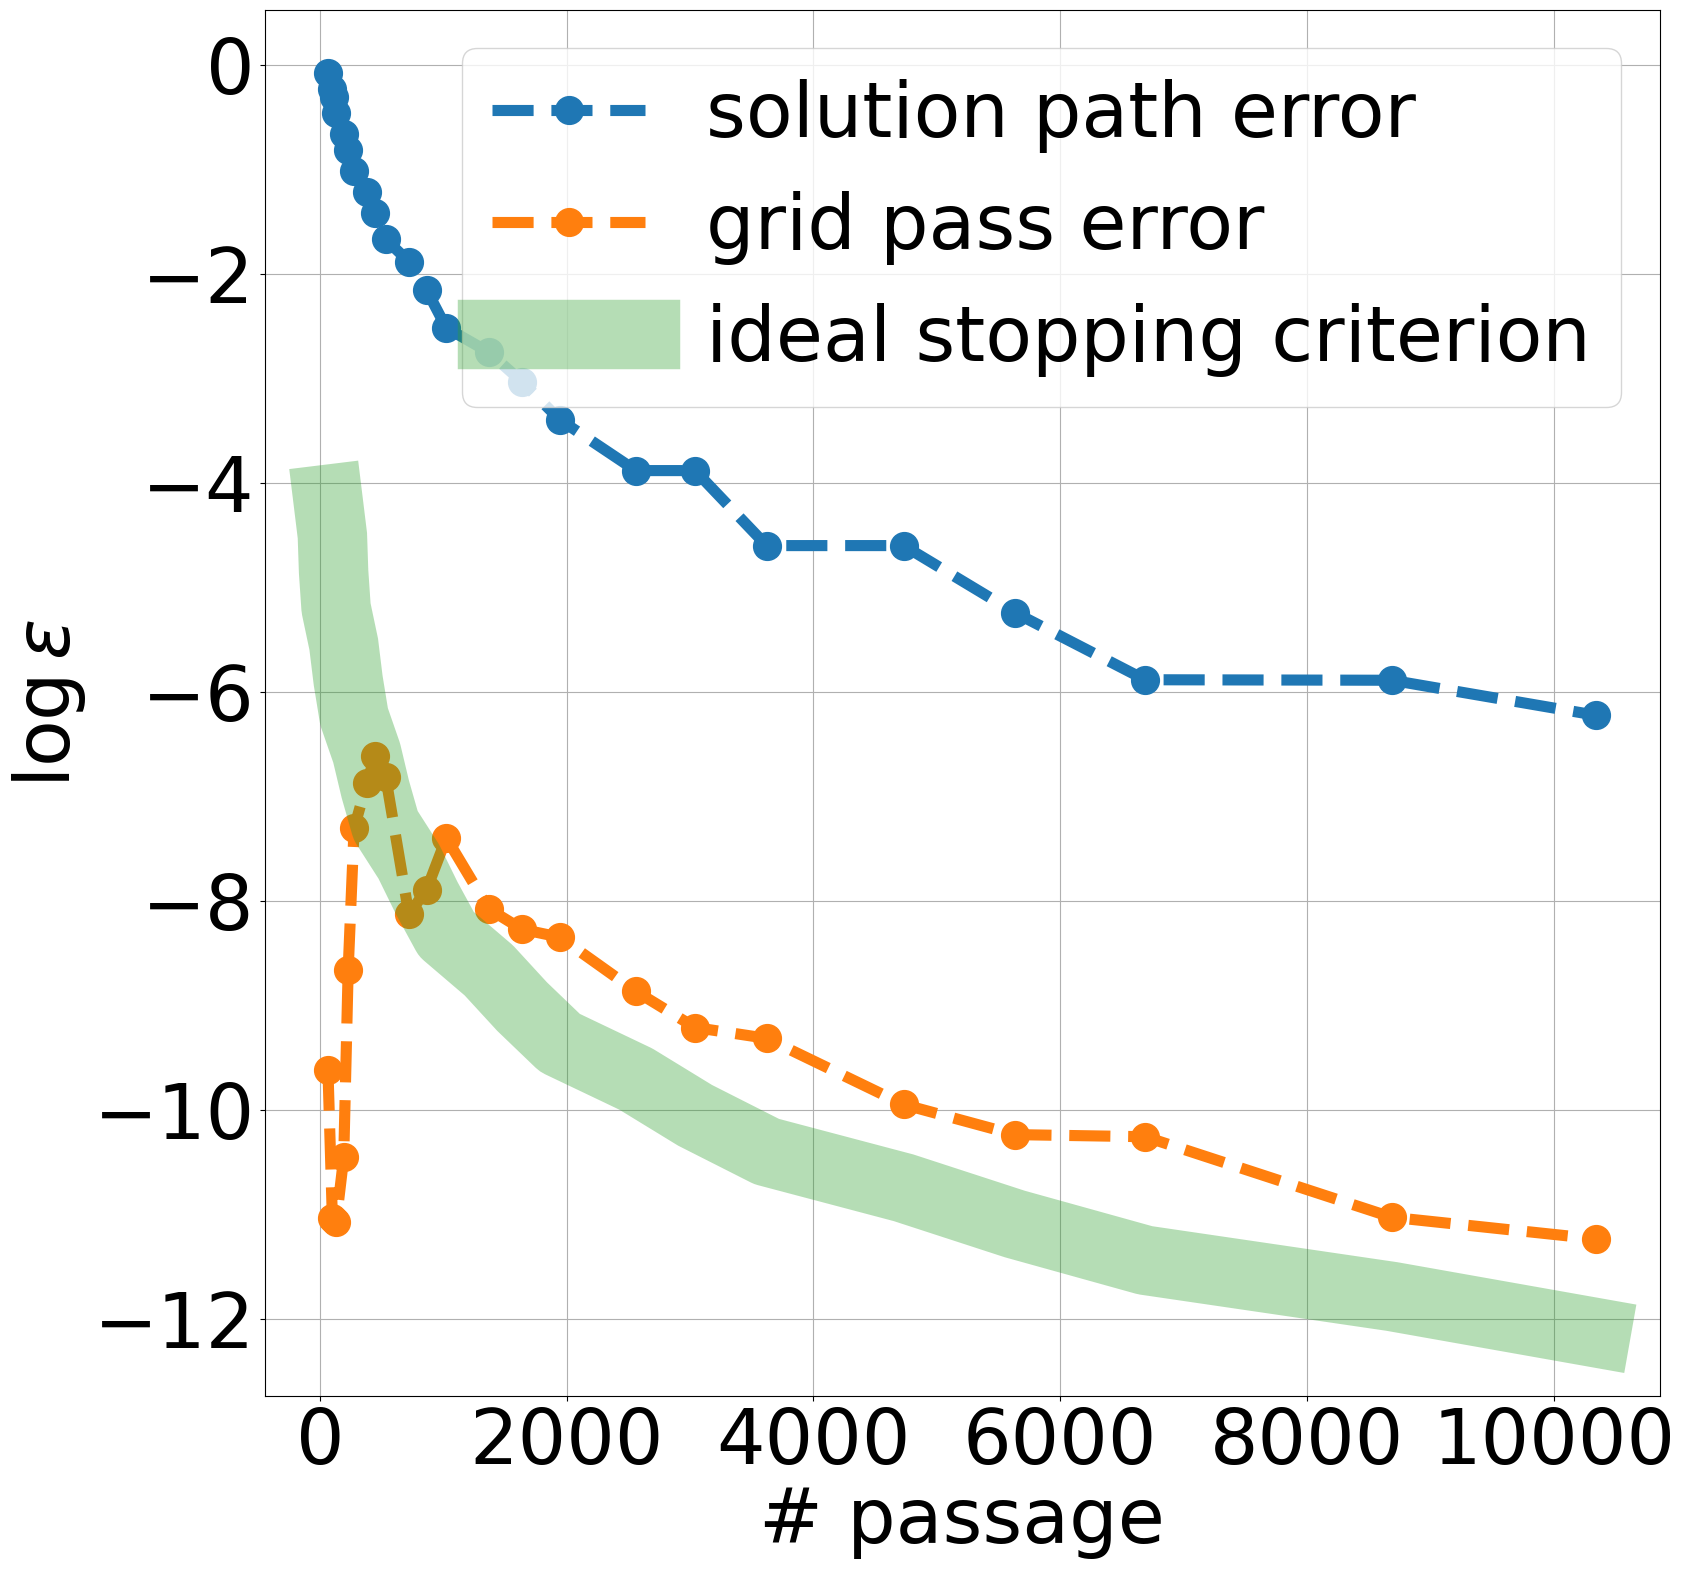

In [23]:
# plot result of learning the solution path
plt.figure(figsize=(18,18))
plt.plot(total_pass_list, np.log(sup_error_list), '--o', linewidth=8, markersize=20, label="solution path error")
plt.plot(total_pass_list, np.log(grid_error_list), '--o', linewidth=8, markersize=20, label="grid pass error")
plt.plot(total_pass_list, np.log(delta_list), '-', linewidth=50, label="ideal stopping criterion", alpha=0.35)

# Set global font size
mpl.rcParams['font.size'] = 55

font_size = 55
# Tick labels
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

# Legend, if applicable
plt.legend(fontsize=font_size)

plt.xlabel('# passage', fontsize=font_size)
plt.ylabel('$\\log\\epsilon$', fontsize=font_size)
plt.legend()
plt.grid(True)
plt.savefig("NGS_stopping_criterion_exact.png")